In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('bmh')
%matplotlib inline

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics as metrics
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Exploration
#### Data shapes, columns attributes

In [3]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print('train:', train.shape, '\n', 'test:', test.shape, '\n', '-'*30)
print(train.info())

train: (42000, 785) 
 test: (28000, 784) 
 --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


#### Histogram for 'Label' Column (0 - 9)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

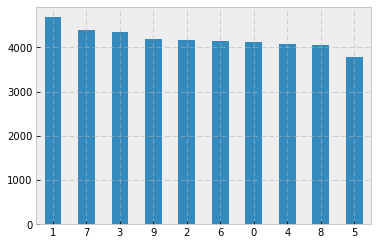

In [8]:
train['label'].value_counts().plot(kind='bar')
plt.xticks(rotation='0')

## Visualizing data point 
#### There are 784 features which could form a '28 * 28 pixel' image

In [5]:
X = train.iloc[:, 1:].values.astype(float)
y = train.iloc[:, :1].values.ravel()

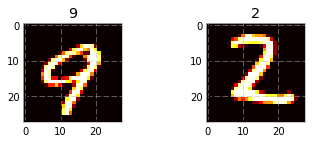

In [149]:
X_reshape = X.reshape(X.shape[0], 28, 28)

for i in range(100, 102):
    plt.subplot(120 + (i+1))
    plt.imshow(X_reshape[i], cmap=plt.get_cmap('hot'))
    plt.title(y[i])

#### Since RGB(255, 255, 255) color has range from 0 to 255
#### For '9' and '2', we can also plot the histogram to see the differences among those pixel values( 784 pixel features)

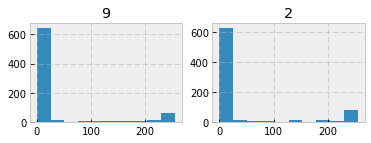

In [150]:
for i in range(100, 102):
    plt.subplot(120 + (i+1))
    plt.hist(X_reshape[i].ravel())
    plt.title(y[i])

## Principal component analysis (PCA) 
#### Dimensionality reduction via PCA on 784 features
whiten = True ==>> the components_ vectors are multiplied by the square root of n_samples and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.

svd_solver='auto' ==>> the solver is selected by a default policy based on X.shape and n_components: if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ‘randomized’ method is enabled. Otherwise the exact full SVD is computed and optionally truncated afterwards.

#### Next, 'cumulative sum' the percentage of variance explained by each of the selected components, plot them over the number of features. 

[ 0.99104413  0.99114032  0.9912356   0.99133035  0.99142483  0.99151642
  0.9916068   0.99169577  0.99178452  0.99187264]


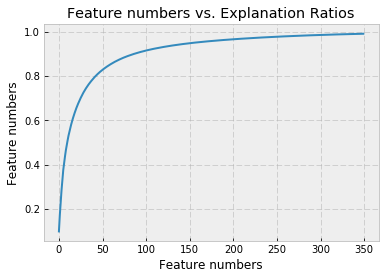

In [153]:
pca = PCA(n_components=350, whiten=True, svd_solver='auto')
pca.fit(X)

ratios = pca.explained_variance_ratio_.cumsum()
print(ratios[-10:])
plt.plot(ratios)
plt.xlabel('Feature numbers')
plt.ylabel('Feature numbers')
plt.title('Feature numbers vs. Explanation Ratios')

### Considering the trade-off of Computational Complexity

In [190]:
variance_explained = [0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]
for percentage in variance_explained:
    features_num = list(ratios).index(ratios[ratios>percentage][0])
    print('Complexity:', features_num, '===>>' 'variance_explained:', percentage)

Complexity: 42 ===>>variance_explained: 0.8
Complexity: 86 ===>>variance_explained: 0.9
Complexity: 153 ===>>variance_explained: 0.95
Complexity: 178 ===>>variance_explained: 0.96
Complexity: 212 ===>>variance_explained: 0.97
Complexity: 259 ===>>variance_explained: 0.98
Complexity: 330 ===>>variance_explained: 0.99


#### Transform train data based on PCA

In [6]:
pca = PCA(n_components=50, whiten=True)
pca_X = pca.fit_transform(X)
pca_X.shape

(42000, 50)

## Model Performances Evaluation

#### Train model with 20000 out of 42000 data points from train data set

In [8]:
X_sample = pca_X[:20000]
y_sample = y[:20000]

print('X_sample:', X_sample.shape, '|', 'y_sample:', y_sample.shape)

X_sample: (20000, 50) | y_sample: (20000,)


##### Define model performance function, it returns model accuracy, 10-fold cross validation mean scores on sampled test data, and the time cost 

In [9]:
def model_performance(model):
    start = time.clock()
    cv_mean_score = cross_val_score(model, X_sample, y_sample, cv=10).mean()
    time_cost = (time.clock() - start)
    print(model, ' ===>>', 'CV Mean Score:', cv_mean_score, '|', 'time_cost:', time_cost, '\n')

#### For each model, if I perform the parameters tuning, say I search the best K for knn (k = range(1, 15) with weights=['distance', 'uniform']), it cost too much time even we only use 20000 data points for testing, and have reduced the feature complexity. 
##### Hence for quick comparison, here the default or simple parameters are used for each model, just see what are the performance baselines before parameters tuning.

In [10]:
knn = KNeighborsClassifier(weights='distance')
svc = svm.SVC()
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=80)

#### Support Vector Machine achieve the highest accuracy among its competitors

In [11]:
models = [knn, svc, lr, rf]
for model in models:
    model_performance(model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')  ===>> CV Mean Score: 0.953350921701 | time_cost: 115.88086726850759 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)  ===>> CV Mean Score: 0.974199547979 | time_cost: 241.11529785860236 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)  ===>> CV Mean Score: 0.8971983875 | time_cost: 51.87894179998062 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_no

### Searching for best parameters for Support Vector Machine
###### The 'gamma' parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. gamma can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.
###### The 'C' parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors.

In [ ]:
svc = svm.SVC(gamma='auto')
C_range = np.logspace(-2, 3, 6)
param_grid = {'C':C_range}

search = GridSearchCV(svc, param_grid, scoring='accuracy')
search_fit = search.fit(X_sample, y_sample)

svc = search_fit.best_estimator_

# Output Predictions

In [74]:
test = pca.transform(test)
test.shape

(28000, 50)

In [76]:
svc.fit(pca_X, y)
pred = svc.predict(test)

df = pd.DataFrame({'ImageId': range(1, len(test)+1), 'Label':pred})
df.to_csv('Predictions.csv', index=False)
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3
